# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# import packages and libraries
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer


In [2]:
# Use this space for any additional import statements you need
import nltk
import string


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
# Define descriptive stats function (module 2)
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_total_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_total_tokens if num_total_tokens > 0 else 0
    num_characters = sum(len(token) for token in tokens)

    # Get the most common tokens
    most_common_tokens = Counter(tokens).most_common(num_tokens)
    
    if verbose:        
        print(f"There are {num_total_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # Print the most common tokens
        print(f"The {num_tokens} most common tokens are:")
        for token, count in most_common_tokens:
            print(f"'{token}' appears {count} times")
        
    return [num_total_tokens, num_unique_tokens, lexical_diversity, num_characters]

 # Defined emojis function   
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# Define function to remove stopwords
def remove_stop(tokens):
    """
    Remove stopwords from a list of tokens.
    """
    return [token for token in tokens if token.lower() not in sw]

# Define function to remove punctuation
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# define function to tokenize text
def tokenize(text):
    """
    Tokenize the input text by splitting on whitespace. 
    This keeps tokens like '#hashtag' or '2A' intact.
    """
    tokens = whitespace_pattern.split(text)
    return [token for token in tokens if token] 

# Define function to prep pipeline
def prepare(text, pipeline):
    tokens = tokenize(text) 
    for transform in pipeline:
        tokens = transform(tokens) 
    return tokens


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/marvi/GitHub Projects/text-compare/M1 Results/"

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [5]:
# Load Twitter data for Cher
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)
twitter_data['artist'] = "cher"

In [6]:
# Load Twitter data for Robyn
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# Combine data for both Cher and Robyn
twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)
print(twitter_data.head())

    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4              888           2891   

                                         description artist  
0                                                NaN   cher  
1           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   cher  
2          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   cher  
3                                                csu   cher  
4  Writer @Washinformer @SpelmanCollege alumna

In [7]:
# read in the lyrics here

# Base folder for the lyrics data
data_location = "C:/Users/marvi/GitHub Projects/text-compare/M1 Results/"
lyrics_folder = data_location + "lyrics/"

# Define the subfolders for Cher and Robyn
artist_folders = {
    'cher': 'cher/', 
    'robyn': 'robyn/' 
}

# Initialize an empty list to store the lyrics data
lyrics_data = []

# Function to read all text files in a folder
def read_lyrics_from_folder(artist, folder_path):
    lyrics_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                lyrics = file.read() 
                song_title = filename.replace('.txt', '')
                lyrics_list.append({
                    'song_title': song_title,
                    'artist': artist,
                    'lyrics': lyrics
                })
    return lyrics_list

# Read Cher's lyrics
cher_lyrics = read_lyrics_from_folder('cher', lyrics_folder + artist_folders['cher'])

# Read Robyn's lyrics
robyn_lyrics = read_lyrics_from_folder('robyn', lyrics_folder + artist_folders['robyn'])

# Combine both artists' lyrics
lyrics_data.extend(cher_lyrics)
lyrics_data.extend(robyn_lyrics)

# Convert the list of dictionaries into a DataFrame
lyrics_df = pd.DataFrame(lyrics_data)

# Display a preview of the combined lyrics data
print(lyrics_df.head())

                      song_title artist  \
0                 cher_88degrees   cher   
1  cher_adifferentkindoflovesong   cher   
2                  cher_afterall   cher   
3                     cher_again   cher   
4                     cher_alfie   cher   

                                              lyrics  
0  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...  
1  "A Different Kind Of Love Song"\n\n\n\nWhat if...  
2  "After All"\n\n\n\nWell, here we are again\nI ...  
3  "Again"\n\n\n\nAgain evening finds me at your ...  
4  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...  


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# Download stopwords if not already available
nltk.download('stopwords')

# Initialize stopwords set
stop_words = set(stopwords.words('english'))

# Punctuation set
punctuation = set(string.punctuation)

# Step 1: Function to remove the song title (first line of each file)
def remove_song_title(text):
    # Remove the first line, assuming '\n' separates lines
    return '\n'.join(text.split('\n')[1:])  # Remove the first line (song title)

# Step 2: Casefold to lowercase (more aggressive than .lower())
def to_lower(text):
    if isinstance(text, str):  # Only apply to strings
        return text.casefold()
    return ""  # Return empty string if it's not a string

# Step 3: Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Step 4: Function to remove punctuation
def remove_punctuation(tokens, is_twitter=False):
    if is_twitter:
        # For Twitter: Remove punctuation but keep hashtags and emojis
        return [''.join(char for char in word if char not in punctuation or char == '#') for word in tokens]
    else:
        # For lyrics: Remove all punctuation
        return [''.join(char for char in word if char not in punctuation) for word in tokens]

# Step 5: Function to tokenize the text (split on whitespace)
def tokenize(text):
    return text.split() if isinstance(text, str) else []  # Return empty list if not a string

# Step 6: Create the my_pipeline list of functions
def create_pipeline(is_twitter=False):
    if is_twitter:
        # For Twitter, we skip title removal and customize punctuation handling
        return [to_lower, tokenize, remove_stopwords, lambda tokens: remove_punctuation(tokens, is_twitter=True)]
    else:
        # For lyrics, we include title removal and more aggressive punctuation removal
        return [remove_song_title, to_lower, tokenize, remove_stopwords, remove_punctuation]

# Function to apply the pipeline
def prepare_text(text, pipeline):
    # Apply each function in the pipeline
    for func in pipeline:
        text = func(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Create the pipeline for lyrics
my_pipeline = create_pipeline(is_twitter=False)

# Apply the pipeline to the "lyrics" column in lyrics_df
lyrics_df["tokens"] = lyrics_df["lyrics"].apply(lambda x: prepare_text(x, my_pipeline))

### Processing twitter_data (Pandas DataFrame) using the pipeline
my_pipeline = create_pipeline(is_twitter=True)  # Create the pipeline for Twitter
twitter_data["tokens"] = twitter_data["description"].apply(lambda x: prepare_text(x, my_pipeline))

# Preview the results for both datasets
print("Processed Lyrics Data (DataFrame):")
print(lyrics_df[["song_title", "tokens"]].head())  # Print first 5 processed lyrics

print("\nProcessed Twitter Data (DataFrame):")
print(twitter_data[["artist", "tokens"]].head())  # Print first 5 rows of processed Twitter data

Processed Lyrics Data (DataFrame):
                      song_title  \
0                 cher_88degrees   
1  cher_adifferentkindoflovesong   
2                  cher_afterall   
3                     cher_again   
4                     cher_alfie   

                                              tokens  
0  [stuck, la, aint, got, friends, hollywood, nut...  
1  [world, crazy, sane, would, strange, cant, bel...  
2  [well, guess, must, fate, weve, tried, deep, i...  
3  [evening, finds, door, ask, could, try, know, ...  
4  [whats, about, alfie, moment, live, whats, sor...  

Processed Twitter Data (DataFrame):
  artist                                             tokens
0   cher                                                 []
1   cher    [𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, , 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]
2   cher      [163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]
3   cher                                              [csu]
4   cher  [writer, washinformer, spelmancollege, alumna,...


In [10]:
# Add 'has emoji' column to twitter data
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [11]:
# Generate statistics for emojis in Twitter data descriptions
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
488055,cher,yeehaw drag queen 👩🏼‍🌾 i can fling sticks arou...,"[yeehaw, drag, queen, 👩🏼‍🌾, fling, sticks, aro..."
2808025,cher,🪐💫✨🌞🌈⭐️,[🪐💫✨🌞🌈⭐️]
488322,cher,Stumbling through life in survival mode living...,"[stumbling, life, survival, mode, living, tea,..."
1246883,cher,😀Grade 1 Teacher,"[😀grade, 1, teacher]"
152042,cher,👑,[👑]
2052274,cher,Always on the Grind as they watch. Real Follow...,"[always, grind, watch, real, followers, real, ..."
57644,cher,Independent voter who just went Democratic. #l...,"[independent, voter, went, democratic, #libera..."
1112087,cher,I’m just here on 🌎 to gain some Understanding ...,"[i’m, 🌎, gain, understanding, life, love, adve..."
1179901,cher,"I heart overwatch and booty, that's all there ...","[heart, overwatch, booty, thats, know🖖]"
1984015,cher,I am a dancer singer and a great friend and a ...,"[dancer, singer, great, friend, great, daughte..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One potential area of improvement in the tokenization process could be handling contractions and compound words more effectively. Currently, the tokenization splits the text based solely on whitespace, which may not capture nuances like contractions (e.g., "don't", "I'm") or compound words (e.g., "New-York").

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [12]:
# Combine the tokens back into strings for TF-IDF processing
lyrics_df['lyrics_text'] = lyrics_df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Separate the lyrics into two sets (e.g., by artist or category)
lyrics_set_1 = lyrics_df[lyrics_df['artist'] == 'cher']['lyrics_text'].tolist()
lyrics_set_2 = lyrics_df[lyrics_df['artist'] == 'robyn']['lyrics_text'].tolist()

# Combine both sets into a single list for TF-IDF processing
lyrics_corpus = lyrics_set_1 + lyrics_set_2

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

# Fit the vectorizer on the combined corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_corpus)

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Split the TF-IDF matrix back into two sets
tfidf_set_1 = tfidf_matrix[:len(lyrics_set_1), :].mean(axis=0).A1 
tfidf_set_2 = tfidf_matrix[len(lyrics_set_1):, :].mean(axis=0).A1 

# Create a DataFrame to compare the results
tfidf_comparison_df = pd.DataFrame({
    'Word': feature_names,
    'TF-IDF for Cher': tfidf_set_1,
    'TF-IDF for Robyn': tfidf_set_2
})

# Sort by the highest TF-IDF scores in Set 1 and Set 2 for comparison
tfidf_comparison_df = tfidf_comparison_df.sort_values(by=['TF-IDF for Cher', 'TF-IDF for Robyn'], ascending=False)

# Show the top TF-IDF scores
print("\nTop Words by TF-IDF in Both Sets:")
print(tfidf_comparison_df.head(10))  # Show top 10 words


Top Words by TF-IDF in Both Sets:
     Word  TF-IDF for Cher  TF-IDF for Robyn
56   love         0.152207          0.095726
39     im         0.086790          0.113069
45   know         0.080637          0.099865
85   time         0.064637          0.058915
63     oh         0.062506          0.029529
11   come         0.057299          0.032229
51   like         0.056679          0.097536
58    man         0.055957          0.009014
31  heart         0.055514          0.035509
95    way         0.055499          0.030984


Q: what observations do you make about these data? 

A: For both artists, the most common words found within each set speak of affection (love, to be specific).
Thus, presenting a common theme. However, words like 'love' and 'oh' seem to be more emphasized for Cher which probably means her music has a greater emotional tone. On the contrary, Robyn's music emphasizes words like 'im' and 'like' which give a sense that there is a greater focus on a personal or self-reference language.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
# Parameters
n = 5 

# Token counts for both corpora
corpus_1_tokens = lyrics_df[lyrics_df['artist'] == 'cher']['tokens'].explode().tolist()
corpus_2_tokens = lyrics_df[lyrics_df['artist'] == 'robyn']['tokens'].explode().tolist()

# Count the frequency of tokens in each corpus
corpus_1_counts = Counter(corpus_1_tokens)
corpus_2_counts = Counter(corpus_2_tokens)

# Calculate the total number of tokens in each corpus
corpus_1_total = len(corpus_1_tokens)
corpus_2_total = len(corpus_2_tokens)

# Calculate the concentration of each token in both corpora
corpus_1_concentration = {token: count / corpus_1_total for token, count in corpus_1_counts.items()}
corpus_2_concentration = {token: count / corpus_2_total for token, count in corpus_2_counts.items()}

# Find all tokens that appear at least `n` times in both corpora
tokens_with_min_count = {token for token in corpus_1_counts if corpus_1_counts[token] >= n} & {token for token in corpus_2_counts if corpus_2_counts[token] >= n}

# Create a list to hold the results for each token that passes the cutoff
results = []

for token in tokens_with_min_count:
    corpus_1_count = corpus_1_counts.get(token, 0)
    corpus_2_count = corpus_2_counts.get(token, 0)
    conc_1 = corpus_1_concentration.get(token, 0)  # Keep as ratio
    conc_2 = corpus_2_concentration.get(token, 0)  # Keep as ratio
    
    # Calculate ratio and avoid division by zero
    if conc_2 > 0:
        ratio = conc_1 / conc_2
    else:
        ratio = float('inf')  # Handle cases where conc_2 is 0 (though should be avoided with the filter)
    
    # Append the results as a dictionary
    results.append({
        'Token': token,
        'Corpus 1 Count': corpus_1_count,
        'Corpus 2 Count': corpus_2_count,
        'Concentration 1': f"{conc_1:.6f}",
        'Concentration 2': f"{conc_2:.6f}",
        'Passes cutoff?': "Yes",
        'Ratio': f"{ratio:.2f}" if ratio != float('inf') else "Inf"
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Sort by Ratio in descending order
results_df = results_df.sort_values(by="Ratio", ascending=False)

# Display the top rows of the table
print(results_df.head(10))

       Token  Corpus 1 Count  Corpus 2 Count Concentration 1 Concentration 2  \
376     walk             114               5        0.003266        0.000331   
48      find             135               6        0.003868        0.000397   
265   enough             124               7        0.003553        0.000463   
259  without              84               5        0.002407        0.000331   
268      man             201              12        0.005759        0.000795   
294   strong              76               5        0.002177        0.000331   
44      live              68               5        0.001948        0.000331   
304  believe             139              11        0.003982        0.000728   
353    tears              56               5        0.001604        0.000331   
25      well             163              16        0.004670        0.001059   

    Passes cutoff? Ratio  
376            Yes  9.87  
48             Yes  9.74  
265            Yes  7.67  
259        

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: First, there appears to be a disproportion of ration across tokens in corpus 1 versus corpus 2. This suggests that Corpus 1 has a strong emphasis on specific verbs or emotions related to action or existential feelings (e.g., "walk", "without", "enough"). Second, a thematic difference is also suggested by the greater rations for words like 'strong', 'tears', and 'believe'. The token "well" has a relatively lower ratio compared to other tokens (4.41), meaning it is somewhat more balanced between the two corpora, though still more common in Corpus 1. I do not see any outlier-type of words based on my knowledge of the type of music produced by the 2 artists. 


## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


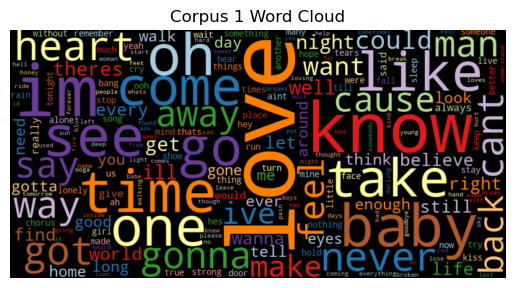

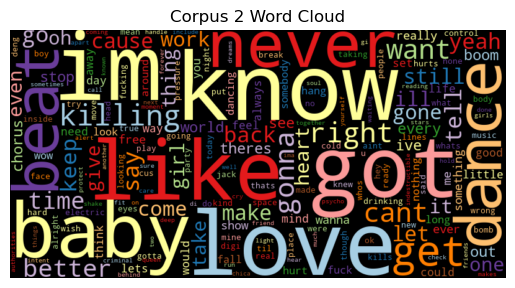

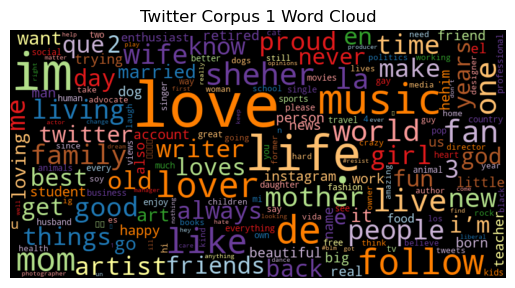

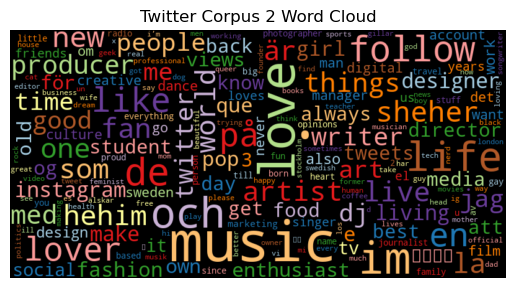

In [15]:
from matplotlib import pyplot as plt

# Step 1: Define the function to count words for each corpus (using your sample)
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

# Step 2: Define the function to generate word clouds (using your sample)
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for token, freq in counter.items() 
                              if token not in stopwords}
    
    wc.generate_from_frequencies(counter)
 
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Step 3: Generate word clouds for all four corpora

# Corpus 1: Example (Artist 1 from lyrics)
corpus_1_df = lyrics_df[lyrics_df['artist'] == 'cher']  # Adjust based on your actual data
word_freq_corpus_1 = count_words(corpus_1_df)
wordcloud(word_freq_corpus_1['freq'], title="Corpus 1 Word Cloud")

# Corpus 2: Example (Artist 2 from lyrics)
corpus_2_df = lyrics_df[lyrics_df['artist'] == 'robyn']  # Adjust based on your actual data
word_freq_corpus_2 = count_words(corpus_2_df)
wordcloud(word_freq_corpus_2['freq'], title="Corpus 2 Word Cloud")

# Corpus 3: Example (Artist 1 from Twitter)
corpus_3_df = twitter_data[twitter_data['artist'] == 'cher']  # Adjust based on your actual data
word_freq_corpus_3 = count_words(corpus_3_df)
wordcloud(word_freq_corpus_3['freq'], title="Twitter Corpus 1 Word Cloud")

# Corpus 4: Example (Artist 2 from Twitter)
corpus_4_df = twitter_data[twitter_data['artist'] == 'robyn']  # Adjust based on your actual data
word_freq_corpus_4 = count_words(corpus_4_df)
wordcloud(word_freq_corpus_4['freq'], title="Twitter Corpus 2 Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word clouds appear to be rather similar between sets (e.g., Twitter data set) relative to common words.
And, as alluded to above, the theme also is similar for each.